# importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# data preprocessing

In [ ]:
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

C_max=2

#renaming columns for simplicity
dataset.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset["current_load"]= abs(dataset["current_load"])

#removing ideling / starting and ending current level data  
df=dataset[(dataset.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df["time"]=df["time"]/3600

#calculate Soc for each cycle
cycle_count=df["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df["Soc"] = [(q / C_max) for q in Soc_list]
df["Soh"]=df["capacity"]/C_max

# dividing dataset

In [17]:
# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

In [16]:
cycle_count

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168])

In [5]:
X = df[att]
Y = df[["Soh"]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [7]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [8]:
#making models
regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())
y_pred_1= regressor1.predict(X_test)

In [9]:
regressor2 = RandomForestRegressor(n_estimators=50,random_state=0)
regressor2.fit(X_train,y_train.values.ravel())            
y_pred_2= regressor2.predict(X_test)

In [10]:
regressor3 = RandomForestRegressor(n_estimators=30,random_state=0)
regressor3.fit(X_train,y_train.values.ravel())
y_pred_3= regressor3.predict(X_test)

In [11]:
def graph_plot(b,a,model):
    plt.plot(X_test[b],y_test,color='red',label='actual',linewidth=4)
    plt.plot(X_test[b],a,color='cyan',label='Node_'+model,linewidth=1)
    plt.xlabel("cycle")
    plt.ylabel("SOH")
    rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, a)))
    plt.figtext(0.33, -0.03, rmse, fontsize=10)
    plt.legend(loc="upper right")
    plt.suptitle("random forest regressor node:"+model)
    plt.show()
    print(np.sqrt(metrics.mean_squared_error(y_test, a)))

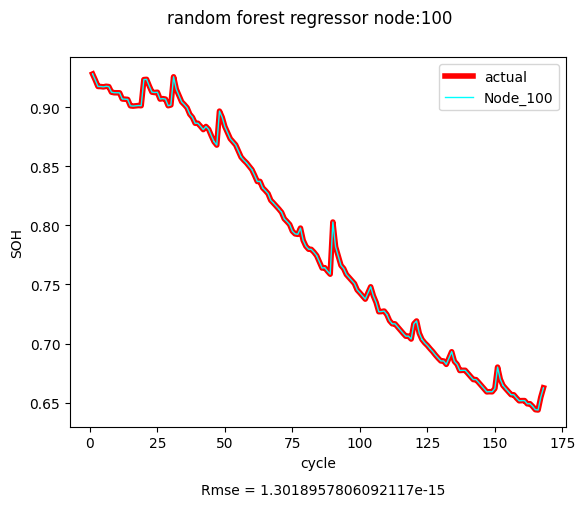

1.3018957806092117e-15


In [12]:
graph_plot(X_axis,y_pred_1,"100")#3.05250135069885e-07

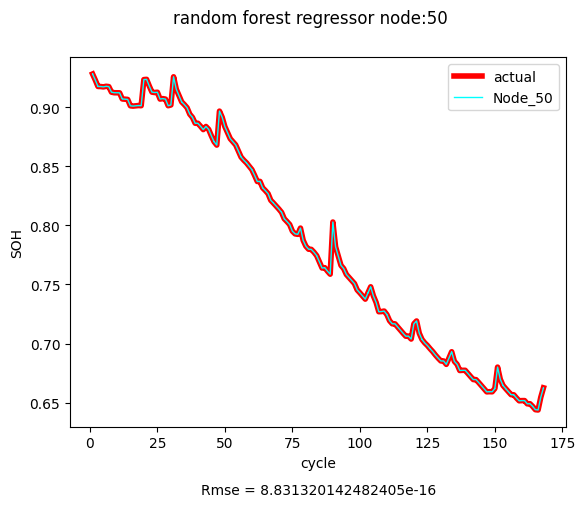

8.831320142482405e-16


In [13]:
graph_plot(X_axis,y_pred_2,"50")#9.70500226793594e-16

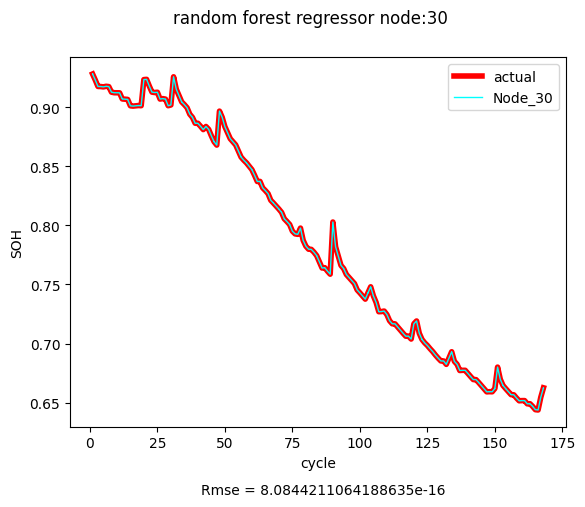

8.0844211064188635e-16


In [14]:
graph_plot(X_axis,y_pred_3,"30")#8.933219312798214e-16